# Stochastic Kronecker Graphical Models - A Finite Mixture Model


We propose the mixture model below for stochastic kronecker graph solutions



<img src="mix_model_1.png" style="width: 30%" align="left">

In the following, we will implement our mixture model and generate examples from it.

In [1]:
# All imports
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Methods being used:

In [2]:
def kronecker_product(mat1, mat2):
    m1 = tf.shape(mat1)[0]
    n1 = tf.size(mat1) // m1
    m2 = tf.shape(mat2)[0]
    n2 = tf.size(mat2) // m2
    mat2_rsh =tf.reshape(mat1, [1, m1, 1, n1])
    mat1_rsh =tf.reshape(mat2, [m2, 1, n2, 1])
    return tf.reshape(mat1_rsh*mat2_rsh, [m1 * m2, n1 * n2])

In [3]:
def addNoise2Mat(mat, mean=0, std=0.01, NRMLZ=True):
    # Set the seed so the results are reproducible.
    np.random.seed(123)
    # Make distribution, sample and add
    p_eta = tfd.Normal(loc=mean, scale=std, name='AdditiveEdgeNoise')
    eta_c = p_eta.sample(tf.shape(mat))
    mat_noise = mat + eta_c
    # Make sure values do not run off
    # Clip values out of [0,1]
    if NRMLZ:
        mat_noise_nrml   = tf.maximum(tf.minimum(mat_noise,1),0)
        return mat_noise_nrml
    else:
        return mat_noise

### Parameters:

In [4]:
theta_shape   = np.array([3,3])
alpha_        = [1.0]
beta_         = [1.0]
K             = 5
NoiseScale    = 0.1

# Run Parameters
NumSamples    = 5

### Mixture Model implementation:

Our mixture model still uses the layered network structure proposed in the work of Stochastic Kronecker Graphs. It relaxes the assumption that the $\theta$ at every kronecker layer is the same. Which means the following:

* $G$ is the adjacency matrix of a large network whose size is $\scriptsize N^K \times N^K$
* $G \sim \Phi$ which is a set of independent binomial distributions on the occurrence of edges
* We assume a set of $\theta_k$ make up the $\Phi$ through successive kronecker products
    
    $\Phi   = \theta^{(1)}\otimes \theta^{(2)} \otimes \dots \theta^{(k)} \dots \otimes \theta^{(K)}$
* If we assume the sizes of each of these $\theta^{(k)}$ are fixed to $N\times N$, then $\Phi_{N^K\times N^k}$
* Further according to our mixture model we allow each $\theta^{(k)}$ to be of a particular "basis" or "class". That is  $\theta^{(k)} \in [\theta_1, \theta_2, \dots, \theta_m, \dots, \theta_M]_{M\rightarrow\infty}$ because we want to model that $\theta^{(k)}$ is drawn from a continuous distribution as shown in our mixture model.


We propose two log-normal distributions which generate $\alpha_k$ and $\beta_k$ values for every $k \in K$

In [16]:
# Sample from separate log-normal distributions to get K number of values for alpha and beta

In [6]:
# Build K number of Beta distributions from alpha and beta values

In [7]:
# Each Beta distribution generates theta_ij values for a single theta

In [8]:
# Sample from mu_k for theta_ij values
alpha  = tf.placeholder_with_default([1.0], [1])
beta   = tf.placeholder_with_default([1.0], [1])
mu_batch_shape   = tf.placeholder(tf.int32)
p_mu   = tfd.Beta(alpha, beta, name='Mu_distb')
mu_batch  = tf.squeeze(p_mu.sample(mu_batch_shape),axis=2)
theta_c   = mu_batch

Use the mu samples as thresholds for theta Bernoulli distributions of edges.

In [9]:
# Use the mu samples as thresholds for 
# theta Bernoulli distributions of edges
theta_c_distb = tfd.Bernoulli(probs=mu_batch, name='theta_c') # Actually never used

Kronecker multiply to obtain the $P_{kc}$

In [10]:
Pk_c   = addNoise2Mat(theta_c)
for i in range(1,K):
    # Add noise to the theta
    itheta_c   =  addNoise2Mat(theta_c, std=NoiseScale)
    # Do kronecker product
    Pk_c   = kronecker_product(Pk_c, itheta_c)

Sample from the $P_{kc}$

In [11]:
Pk_c_distb   = tfd.Bernoulli(probs=Pk_c, name='Pk_c')
G_c          = Pk_c_distb.sample(NumSamples)


### Run and Plot:

In [12]:
sess = tf.Session()
[G, Pk_c_s, theta_c] = sess.run([G_c, Pk_c, mu_batch], 
                                feed_dict={mu_batch_shape:theta_shape,
                                           alpha:alpha_,
                                           beta:beta_
                                          })

In [13]:
print(theta_c)
print(Pk_c_s.shape)
print(G.shape)

[[0.020435   0.95777655 0.05081129]
 [0.8589895  0.9150352  0.20155779]
 [0.47889912 0.26866716 0.67696124]]
(243, 243)
(5, 243, 243)


Text(0.5, 1.0, 'P_k_c')

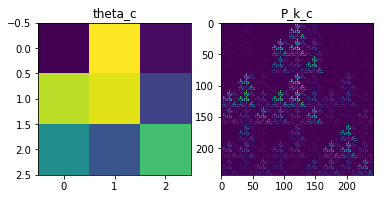

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(theta_c)
plt.title('theta_c')

plt.subplot(1,2,2)
plt.imshow(Pk_c_s)
plt.title('P_k_c')

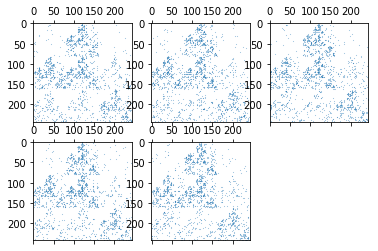

In [15]:
plt.figure()
plt.title('All samples')
r = np.floor(np.sqrt(NumSamples))
c = np.ceil(float(NumSamples)/r)
for i in range(0,NumSamples):
    plt.subplot(r,c,i+1)
    plt.spy(G[i,:], markersize=0.1)